# Setup

Here we import Numpy, Pylab, Matplotlib, SciPy's signal processing toolbox, the Mako templating library & Python interface to Stan (Pystan). Nibabel is used to handle some data. The HTML object lets us inline HTML in the notebook, e.g. displaying tables of data.

In [1]:
import os
import re
import sys
import numpy as np
from numpy import *
from pylab import *
import matplotlib.pyplot as plt
import time

import zipfile
import mne, re
import nibabel

from scipy import signal
from scipy.io import savemat

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

import pystan
#from Rdump import stan_rdump # To save data in R format to run the inference, we need to call pystan. One can call Rdump.py to do this if has a problem to import pystan. 


We can use either inline figures (pylab inline) or matplotlib:

In [2]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


/Users/meysamhashemi/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['linalg', 'draw_if_interactive', 'random', 'power', 'fft', 'info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


All the required data mantioned above are located in the following directory.
You can choose an arbitary directory and give its path as follows:

In [3]:
path = '/Users/meysamhashemi/Work/Codes/PostdocCode/BayesiaCodes/FittingSEEG/Syntheticdata/'

# Plot region and electrode positions

Here we compute the "contacts" from "complex.ades"

In [4]:
contacts = []
with open(path+ 'data/complex.ades', 'r') as fd:
    for line in fd.readlines():
        parts = [p.strip() for p in line.strip().split('=')]
        if len(parts)>1 and parts[1] == 'SEEG':
            name, idx = re.match("([A-Z]+[a-z]*[']*)([0-9]+)", parts[0]).groups()
            idx = int(idx)
            contacts.append((name, idx)) 

Here we compute the names, and xyz positions of regions and the electrodes from "centers.txt", "elecs_name.txt", respectively, and then we plot them in (x, y),  (x,z), and (y,z) coordinates.

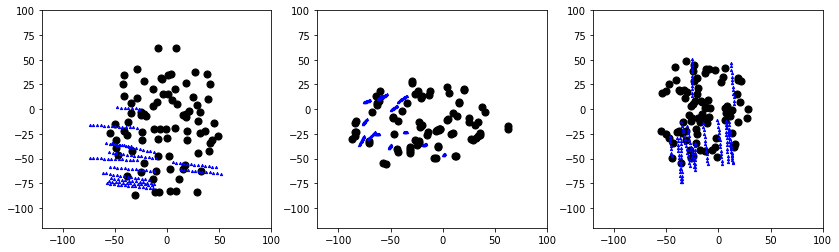

In [5]:
reg_xyz = loadtxt(path+ 'data/centers.txt', usecols=(1,2,3))
reg_names = []
with open(path+ 'data/centers.txt', 'r') as fd:
    #for line in fd.readlines():
     #   reg_names.append(line.strip().split()[0])
    for i, line in enumerate(fd.readlines()):
        reg_names.append('r%03d-%s' % (i, line.strip().split()[0]))
#seg = nibabel.load('aparcaseg_2_diff_2.nii.gz')
#reg_xyz = seg.affine.dot(c_[reg_xyz, ones((reg_xyz.shape[0], ))].T)[:3].T


seeg_labels = []
seeg_xyz = loadtxt(path+ 'data/elecs_name.txt', usecols=(1,2,3))
with open(path+ 'data/elecs_name.txt', 'r') as fd:
    for line in fd.readlines():
        parts = line.strip().split()
        seeg_labels.append(parts[0].upper())
#print sorted(seeg_labels+[e+str(i) for e, i in contacts])
monopolar_chan_to_pos = []
for name, idx in contacts:
    monopolar_chan_to_pos.append(seeg_labels.index(name+str(idx)))
seeg_xyz = array([seeg_xyz[i] for i in monopolar_chan_to_pos])




def plot_electrodes():
    x, y, z = zip(reg_xyz.T, seeg_xyz.T)
    for i, ((ra, sa), (rb, sb)) in enumerate([(x, y), (y, z), (z, x)]):
        subplot(1, 3, i + 1)
        scatter(ra, rb, color='k', s=50)
        scatter(sa, sb ,color='b',marker='^', s=5 )
        axis([-120, 100, -120, 100])
        #xticks([]), yticks([])
figure(figsize=(14, 4))
plot_electrodes()
plt.show()



Now, we plot the centers (regions) and all the givn contacts of electrodes in 3D.

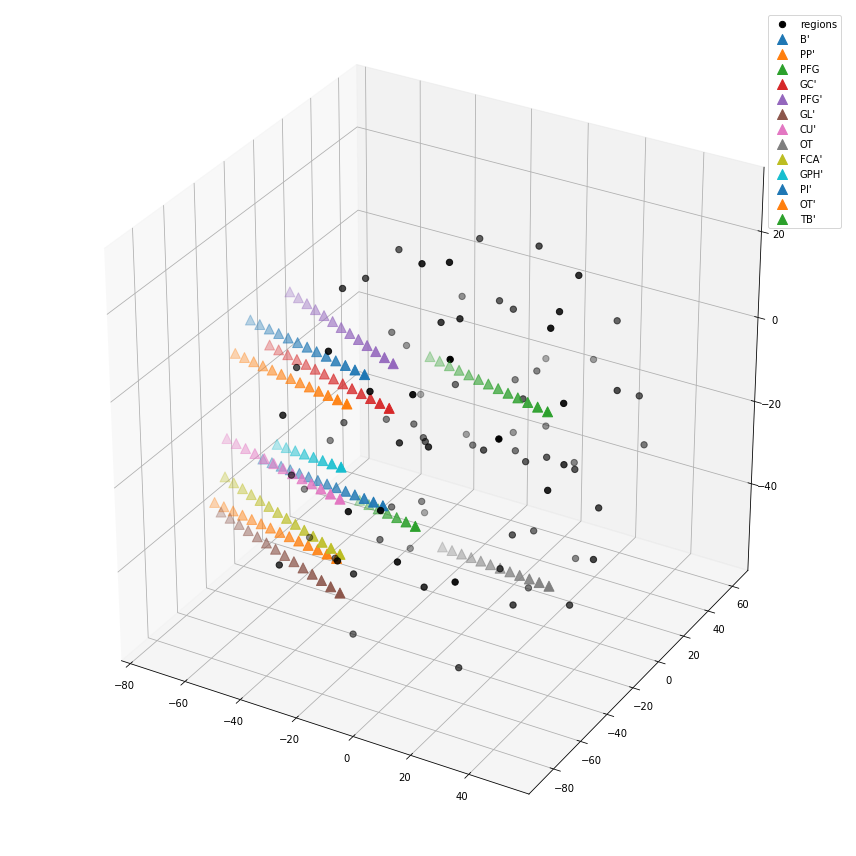

In [6]:
elecnames=[]
electrodes = {}  
with open(path+ 'data/elecs_name.txt', 'r') as fd:
            for i, line in enumerate(fd.readlines()):
                line = line.strip()
                contact, x, y, z = line.split()
                elecnames.append(contact)
                name, _ = re.match("([A-Za-z]+[']*)([0-9]+)", contact).groups()
                if name in electrodes:
                    electrodes[name].append(i)
                else:
                    electrodes[name] = [i]
                    
        
 
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reg_xyz [:, 0], reg_xyz [:, 1], reg_xyz [:, 2], color='k', s=40, label='regions')


for name, idxs in electrodes.items():
    ax.scatter(seeg_xyz [idxs, 0], seeg_xyz [idxs, 1], seeg_xyz [idxs, 2],marker='^', s=100, label=name)
    

plt.legend()
plt.tight_layout()
plt.show()    

# Load complex seizure

From head file "complex.ades" we get sampling Rate and number Of Samples, in addition to all the electode contacts.
We here load this dataset, parsing channel names to obtain the bipolar montage.

In [7]:
contacts = []
seeg_idxs = []
channel_idx = 0
contacts_labels = []

with open(path+ 'data/complex.ades', 'r') as fd:
    for line in fd.readlines():
        parts = [p.strip() for p in line.strip().split('=')]
        if len(parts)>1 and parts[1] == 'SEEG':
            name, idx = re.match("([A-Za-z]+[']*)([0-9]+)", parts[0]).groups()
            idx = int(idx)
            contacts.append((name, idx))             
            seeg_idxs.append(channel_idx)
            contacts_labels.append(parts[0].upper())
            
            channel_idx += 1
 
    
bipnames = []
bipidx = []
for i in range(len(contacts)-1):
    (ln, li), (rn, ri) = contacts[i:i+2]
    if ln != rn:
        continue
    bipnames.append('%s%d-%d' % (ln, li, ri))
    bipidx.append((i, i+1))

In [8]:
print 'The number of contacts is ', channel_idx 
print 'The number of bi-polars is ', len(bipidx) 

The number of contacts is  162
The number of bi-polars is  149


Here, we extract samplingRate and numberOfSamples from complex.ades"

In [9]:
filename=path+ 'data/complex.ades'

with open(filename, 'r') as fd:

            fd.readline() # ADES header file

            kw, sampling_rate = [s.strip() for s in fd.readline().strip().split('=')]
            assert kw == 'samplingRate'
            sampling_rate = float(sampling_rate)

            kw, nsamples = [s.strip() for s in fd.readline().strip().split('=')]
            assert kw == 'numberOfSamples'
            nsamples = int(nsamples)

In [10]:
print 'The sampling rate is ', sampling_rate 
print 'The number of samples is ', nsamples 

The sampling rate is  1000.0
The number of samples is  6000


Here, we compute time series according to sampling rate and number of samples as computed above.

In [11]:
t=np.linspace(0, (nsamples - 1)*(1./sampling_rate), nsamples)
delta_t=t[2001]-t[2000]

In [12]:
print  'The time increment dt is ', delta_t 

The time increment dt is  0.001


# Plot time series

Here, we load the time series of all contacts from complex.npy

In [13]:
data=load(path+'data/complex.npy')

In [14]:
print  'The shape of data is ', data.shape

The shape of data is  (162, 6000)


Here, we plot the raw time series.

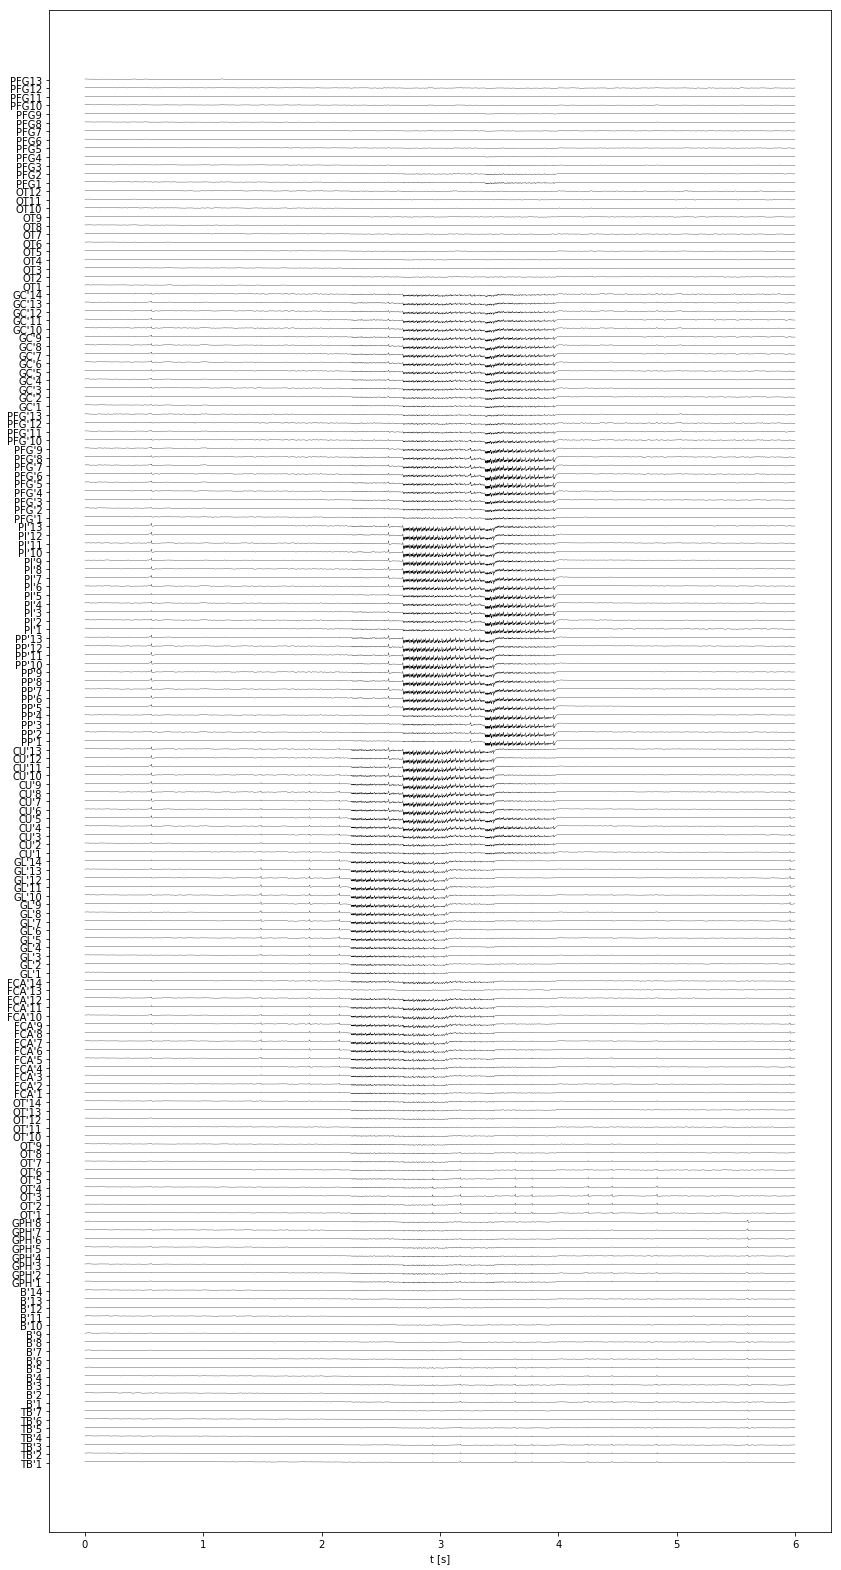

In [15]:
numberofcontacts=len(contacts)

plt.figure(figsize=(14, 28))

for i in range(numberofcontacts):
    plt.plot(t, 1e+0*data[i, :] + i, 'k', lw=0.3)
    
plt.xlabel("t [s]")
plt.yticks(np.r_[:numberofcontacts], [a + str(b) for a, b in contacts])
plt.show() 

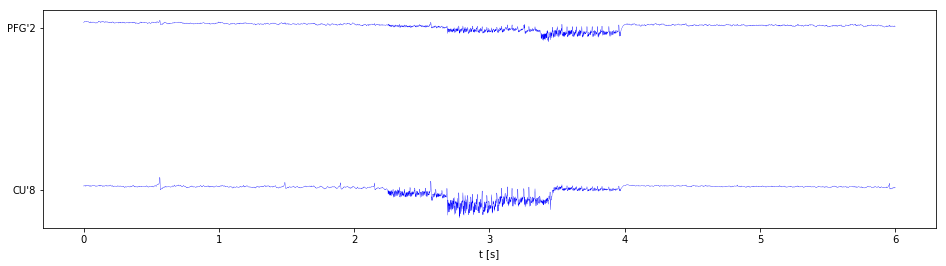

In [16]:
selectedlabels=["CU'8", "PFG'2"]

selectedcontacts=[]
for s in selectedlabels:
    name, idx=re.match("([A-Za-z]+[']*)([0-9]+)", s).groups()
    idx = int(idx)
    selectedcontacts.append((name, idx))
#selectedcontacts=[re.match("([A-Za-z]+[']*)([0-9]+)", s).groups() for s in selectedlabels]
    
    
indices = [contacts_labels.index(c) for c in selectedlabels]
plt.figure(figsize=(16, 4))

for i in range(len(indices)):
    plt.plot(t, data[indices[i], :] + 4*i, 'b', lw=0.3)
 
plt.xlabel("t [s]")
plt.yticks(4*np.r_[:len(selectedlabels)], [a + str(b) for a, b in selectedcontacts])
plt.show() 

In [17]:
seeg = data
#seeg = data[:, 600:-400]

bip = array([seeg[i] - seeg[j] for i, j in bipidx])

fs=sampling_rate  
t = r_[:seeg.shape[1]]/fs

In [18]:
print  'The shape of seeg data is ', seeg.shape
print  'The shape of bipolar is ', bip.shape

The shape of seeg data is  (162, 6000)
The shape of bipolar is  (149, 6000)


Here we plot the obtained bipolar montage (non-filtered bipolar).

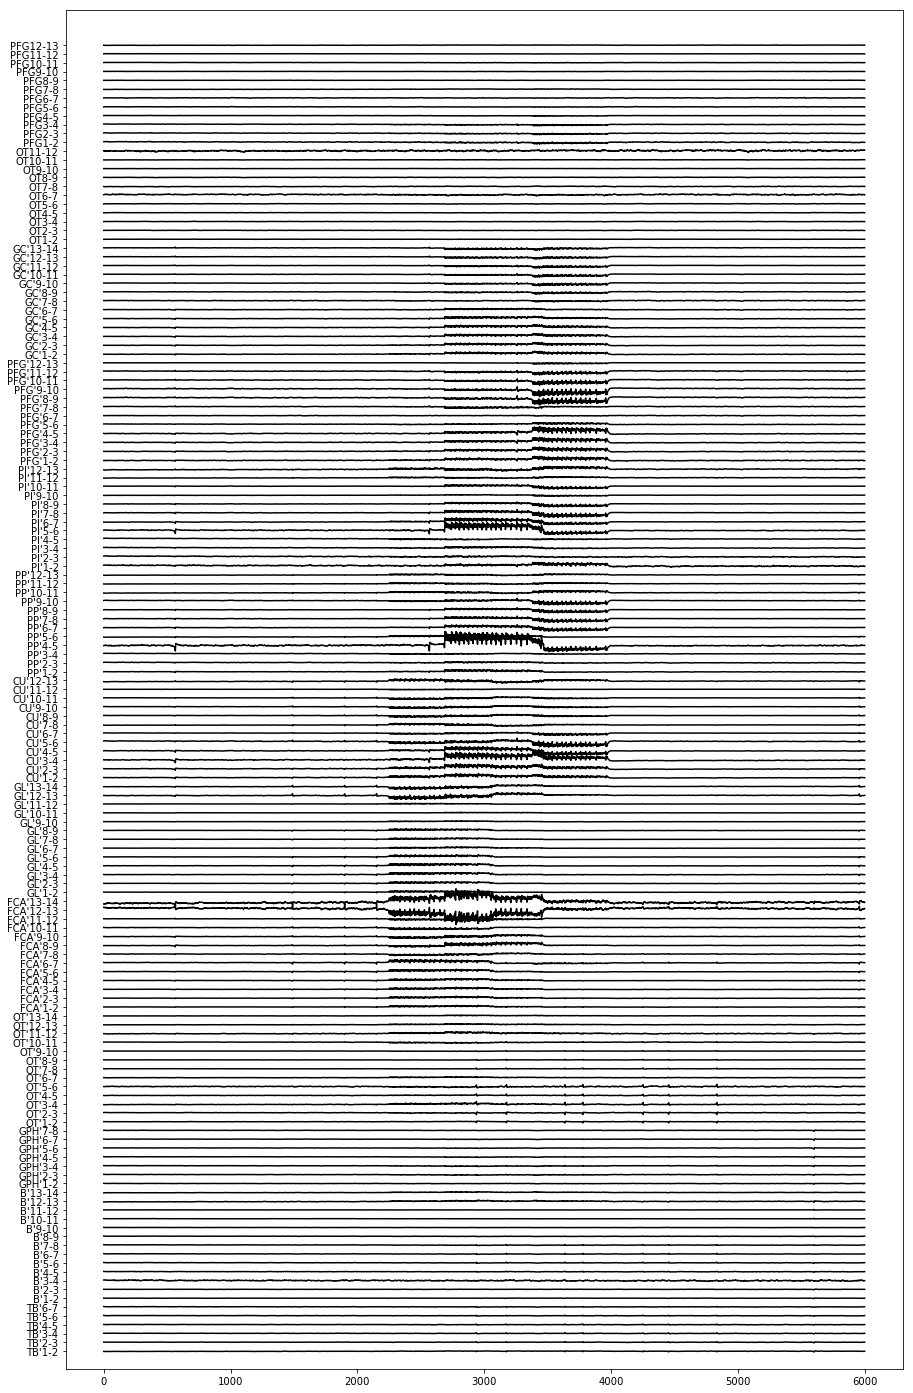

In [19]:
y=bip
figure(figsize=(15, 25))
for i, yi in enumerate(y):
    plot(0.5e+1*yi+ i, 'k')
yticks(r_[:bip.shape[0]], bipnames);
ylim([-2, bip.shape[0]+3]);
plt.show() 

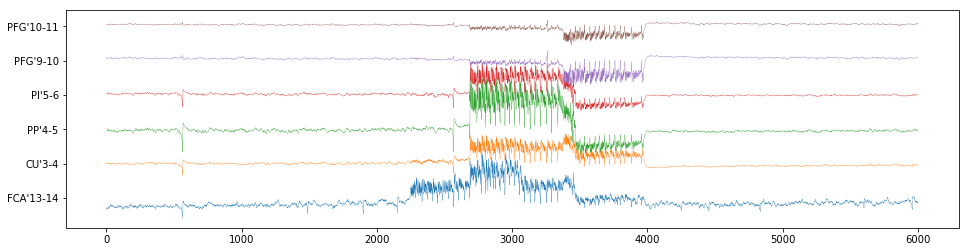

In [20]:
selectedlabels=[ "FCA'13-14", "CU'3-4", "PP'4-5", "PI'5-6", "PFG'9-10","PFG'10-11"]

indices = [bipnames.index(c) for c in selectedlabels]

biplist=[]
for i in range(len(indices)):
     biplist.append(bipnames[indices[i]])
        
yy=bip[indices, :]

figure(figsize=(16, 4))
for i, yi in enumerate(yy):
    plot(0.5e+1*yi+ i, lw=0.3)
yticks(r_[:len(indices)], biplist);
plt.show()

# Filter & decimate

Here, we preprocess to select a frequency band of interest (4 - 30Hz) & reduce the size of the data.

In [21]:
nyq = 0.5 * fs
low_f = 4.0 / nyq
high_f = 30. / nyq
b, a = signal.butter(3, [low_f, high_f], 'pass') #b, a = signal.butter(3, 2*r_[4, 30]/fs, 'pass')
y = signal.lfilter(b, a, bip, axis=1)
y = y[:, ::15] # decim ~ 30 Hz
t = t[::15]
t = (np.r_[:seeg.shape[1]]/fs)[::15]

fs = 1/(t[1] - t[0])


In [22]:
print 'The effective fs after decimation is %0.2f Hz' % (fs, )
print y.shape
print bip.shape

The effective fs after decimation is 66.67 Hz
(149, 400)
(149, 6000)


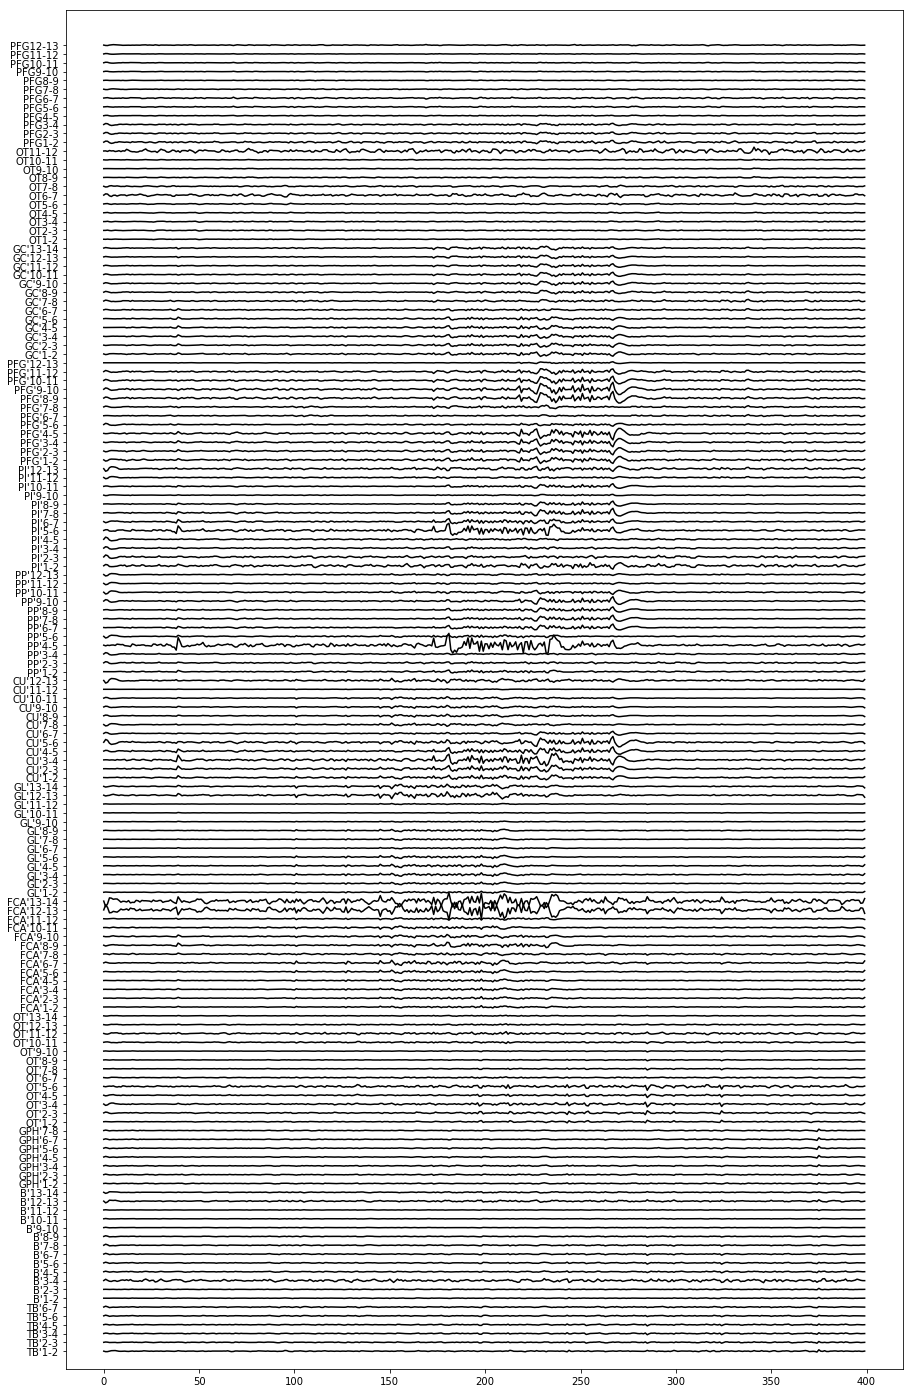

In [23]:
figure(figsize=(15, 25))
for i, yi in enumerate(y):
    plot(2e+1*yi + i, 'k')
yticks(r_[:bip.shape[0]], bipnames);
ylim([-2, bip.shape[0]+3]);
plt.show() 


# Select Contacts

Here, we use mean energy of diff to pick for instance 6 channels.

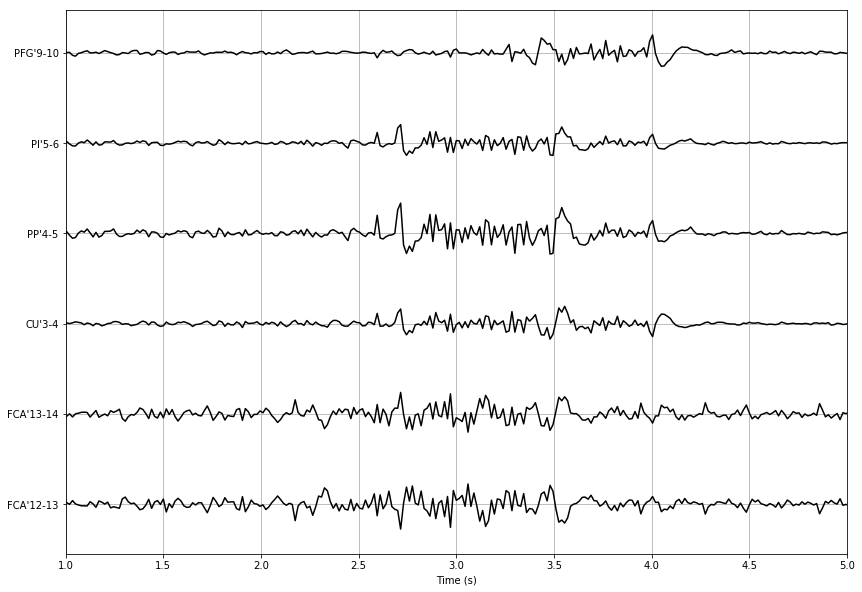

In [24]:
NumberofContacts=6

db2 = diff(bip, axis=1)**2
eni = argsort(mean(db2, axis=1))
eni = array(sort(eni[-NumberofContacts:]))


figure(figsize=(14, 10))
for i, yi in enumerate(y[eni]):
    plot( t, 0.5e+1*yi+ i, 'k')
yticks(r_[:len(eni)], [bipnames[i] for i in eni]);
grid(True)
xlabel('Time (s)');
xlim([1, 5]);
plt.show() 

It can be observed that the seizure manifests between `t=1` & `t=5`, so we'll work only with that section.

In [25]:
#tm = c_[t>1., t<5.].all(axis=1)
#savemat('complex.mat', {'t': t.astype('f'), 's': y.astype('f')})
#!ls -lh complex.mat

tm = c_[t>2., t<2.1].all(axis=1)
print 'section contains %d samples' % (tm.sum(), ) 

section contains 6 samples


# Select Nodes

In [26]:
dr = reg_xyz - seeg_xyz[:, newaxis]
ndr = sqrt((dr**2).sum(axis=-1))
Vr = 1.0 / (4 * pi) / ndr**2
bVr = array([Vr[i] - Vr[j] for i, j in bipidx])

#save('Vr.npy', Vr)
#Vr=loadtxt('gain_inv-square.mat')
#Vr=loadtxt('gain_dipole_no-subcort.mat')

we set some default options for follwoing figures.

In [27]:
from matplotlib import rc
rc('lines', color='k')
rc('figure', figsize=(15, 5))
rc('image', cmap='binary', interpolation='nearest')
rc('patch', facecolor='k')
rc('axes', edgecolor='white')

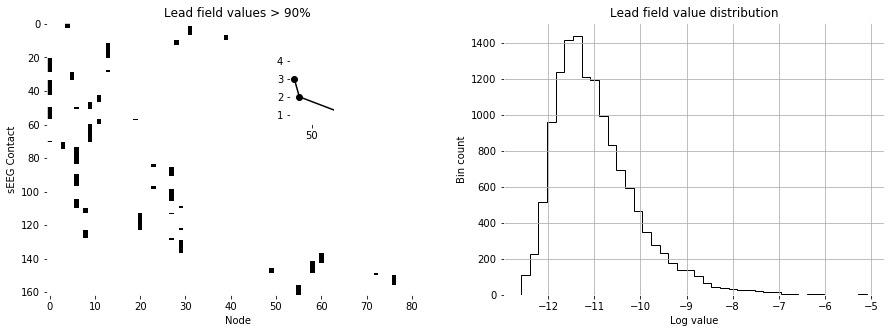

In [28]:
figure(figsize=(15, 5))
subplot(121)
nVr = Vr/Vr.max(axis=1)[:, newaxis] > 0.9
imshow(nVr, interpolation='nearest', aspect='auto')#, vmin=0.5, vmax=0.9)
title('Lead field values > 90%'), xlabel('Node'), ylabel('sEEG Contact')
a = axes([.35, .6, .04, .2])
n = bincount(nVr.sum(axis=1))
plot(n[1:], r_[1:len(n)], 'ko-')
yticks([1, 2, 3, 4]), xticks([50]), ylim([0.5, 4.5]), xlim([-10, 110])
subplot(122), hist(log(Vr).reshape((-1,)), 40, color='k', histtype='step'), grid(1);
title('Lead field value distribution'), xlabel('Log value'), ylabel('Bin count');
plt.show()

We will allow $\sigma$ to vary during inference, and thus drop it from the lead field calculation. Finally, for lack of high resolution in spatial geometry, the orientations of the sources are largely unknown and thus ignored. To make the correspondence between contacts and nodes clearer, the lead field is normalized by maximum per row and thresholded at 90%, and the inset shows a histogram of nodes (y-axis) exceeded the 90% threshold for contacts (x-axis).
 
For the current purposes, we asssume that few nodes in the whole brain network play a role in the seizure and thus contribute to the observed seizure. This allows us to reduce the number of electrodes and number of nodes in the network on which the inference is performed.

In [29]:
actnodes = []
Ps=[]
for i in eni:
    ii = bipidx[i]
    ni = find(nVr[ii[0]:ii[1]+1].any(axis=0))
    print("%15s %45s" % (bipnames[i], ', '.join([reg_names[j] for j in ni])))
    Ps.append(i)
    actnodes += ni.tolist()
actnodes = unique(actnodes)


print "The selected Nodes are : ", actnodes
print "The selected contacts are : ", Ps

      FCA'12-13                          r000-ctx-lh-bankssts
      FCA'13-14                          r000-ctx-lh-bankssts
         CU'3-4 r003-ctx-lh-cuneus, r006-ctx-lh-inferiorparietal
         PP'4-5                  r027-ctx-lh-superiorparietal
         PI'5-6                  r027-ctx-lh-superiorparietal
       PFG'9-10                       r020-ctx-lh-postcentral
The selected Nodes are :  [ 0  3  6 20 27]
The selected contacts are :  [50, 51, 67, 80, 93, 109]


### Connectivity

Fiber tracking from grey-white matter boundaries performed on DTI, along with the chosen parcellation, generates a "weight" matrix out of fiber counts. To reduce symmetry breaking in the dynamics, this connectivity is normalized with respect to its afferents.

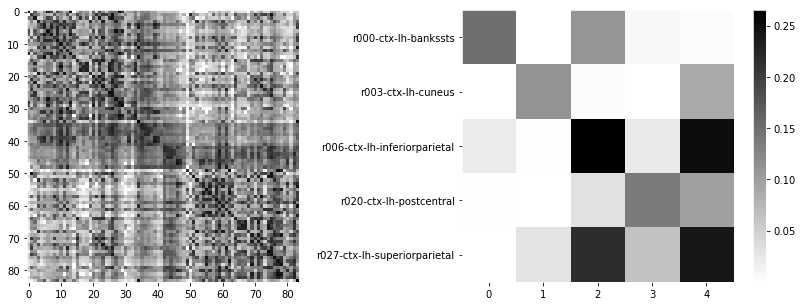

In [30]:
K_raw = loadtxt(path+ 'data/weights.txt')
K = K_raw * 1.0 / K_raw.sum(axis=1)[:, newaxis]
subplot(121)
imshow(log(K+1e-5), interpolation='nearest')

subplot(122)

imshow(K[actnodes][:, actnodes])
yticks(r_[:len(actnodes)], [reg_names[i] for i in actnodes]);
colorbar();
plt.show()

# Fitting target

we use an observation model that incorporates the sEEG forward solution described above, under the assumption that the x1 variable describes fluctuations in the log power of high frequency activity, predicting sensor log power, with normally distributed observation error.

The sEEG data are windowed and Fourier transformed to obtain estimates of their spectral density over time. Then sEEG power above 10 Hz is summed to capture the temporal variation of the fast activity. These time series are corrected to a preictal baseline, log-transformed and linearly detrended over the time window encompassing the seizure.

In [31]:
from numpy import load, array, log
from pylab import specgram, ion, ioff, detrend_linear

from matplotlib import rc
rc('lines', color='k')
rc('patch', facecolor='k')
rc('axes', edgecolor='Black')

In [32]:
#seeg = load('complex.npy')
#seeg = data[:, 600:-400]
seeg = data

fs=1000.  #int(1.0 / dt)
nfft=1000  #int(2**ceil(math.log(seeg.shape[1],2))) #Noverlap=240
Noverlap=990
flo=10.0
tb=10.0

def log_power_change(seeg, flo, nfft, fs, tb):  
    ioff()
    ps = []
    for chan in seeg:
        P, F, T, _ = specgram(chan, NFFT=nfft, Fs=fs, noverlap=Noverlap) 
        p = P[F>flo].sum(axis=0)
        p /= p[T<tb].mean()
        ps.append(detrend_linear(log(p)))
    return T, array(ps)

In [33]:
print seeg.shape
print bip.shape

(162, 6000)
(149, 6000)


In [34]:
T, ps = log_power_change(seeg, flo, nfft, fs, tb )
plt.close()

print "Time dimension is", T.shape
print "ps dimension is ", ps.shape

Time dimension is (501,)
ps dimension is  (162, 501)


In [35]:
T -= T[0]
dt = T[1] - T[0]

print "dt based on psd is ", dt

dt based on psd is  0.01


In [ ]:
figure(figsize=(10, 3))
plot(T, ps.T, 'k', alpha=0.2)
ylabel('sEEG (t)');
xlabel('Time (s)');
plt.show()

In [37]:
picks = asarray(Ps)

print "The slected contacts (picks) are: ", picks

The slected contacts (picks) are:  [ 50  51  67  80  93 109]


In [38]:
print  'The shape of ps is ', ps.shape
print  'The shape of T is ', T.shape

The shape of ps is  (162, 501)
The shape of T is  (501,)


In [39]:
nodes=list(actnodes)
print "The slected nodes are: ", nodes

The slected nodes are:  [0, 3, 6, 20, 27]


 It is arbitrary to add more specific nodes according to clinical information. For instance, for this case study 
 EZ=[9],  PZ=[5,6]. One can add them to the above obtained selected nodes.


In [40]:
Ezlist=[ "ctx-lh-lateraloccipital"]
Pzlist=[ "ctx-lh-fusiform", "ctx-lh-inferiorparietal"]
 

reg_names = []
with open(path+ 'data/centers.txt', 'r') as fd:
    for i, line in enumerate(fd.readlines()):
        reg_names.append(( line.strip().split()[0]))
        


Ez_indices = [reg_names.index(c) for c in Ezlist]
Pz_indices = [reg_names.index(c) for c in Pzlist]


Ez = np.asarray(Ez_indices,dtype=float)   
Pz = np.asarray(Pz_indices,dtype=float)

In [41]:
print "The Ez list according to clinician is: ", Ezlist
print "The Pz  list according to clinician is: ",Pzlist

print "The indices of Ez are: ", Ez_indices
print  "The indices of Pz are: ", Pz_indices

#nodes.extend(Ez_indices)
#nodes.extend(Pz_indices)

print  "The pre-selected nodes are: ", nodes

The Ez list according to clinician is:  ['ctx-lh-lateraloccipital']
The Pz  list according to clinician is:  ['ctx-lh-fusiform', 'ctx-lh-inferiorparietal']
The indices of Ez are:  [9]
The indices of Pz are:  [5, 6]
The pre-selected nodes are:  [0, 3, 6, 20, 27]


Contacts are selected, which present greater high-frequency activity than their neighbors on the same electrode. Given that, contrary to M/EEG, the sEEG lead field is very sparse, three nodes per contact are used in the network model. Other nodes are not recruited and rest at their fixed points

In [42]:
for i in picks:
    _ = argsort(Vr[i])[-3:].tolist()
    nodes += _
    print("%r picks %r" % (bipnames[i], [reg_names[ii] for ii in _]))
nodes = unique(nodes)  

print  "The selected nodes are: ", nodes

#    _ = argsort(Vr[i])[-4:].tolist()  # this gives node number 5


"FCA'12-13" picks ['ctx-lh-inferiorparietal', 'ctx-lh-bankssts', 'ctx-lh-lateraloccipital']
"FCA'13-14" picks ['ctx-lh-lateraloccipital', 'ctx-lh-inferiorparietal', 'ctx-lh-bankssts']
"CU'3-4" picks ['ctx-lh-bankssts', 'ctx-lh-inferiorparietal', 'ctx-lh-lateraloccipital']
"PP'4-5" picks ['ctx-lh-bankssts', 'ctx-lh-lateraloccipital', 'ctx-lh-inferiorparietal']
"PI'5-6" picks ['ctx-lh-supramarginal', 'ctx-lh-superiorparietal', 'ctx-lh-inferiorparietal']
"PFG'9-10" picks ['ctx-lh-superiorparietal', 'ctx-lh-supramarginal', 'ctx-lh-inferiorparietal']
The selected nodes are:  [ 0  3  6  9 20 27 29]


The final selected nodes are:  [ 0  3  6  9 20 27 29]
['ctx-lh-bankssts', 'ctx-lh-cuneus', 'ctx-lh-inferiorparietal', 'ctx-lh-lateraloccipital', 'ctx-lh-postcentral', 'ctx-lh-superiorparietal', 'ctx-lh-supramarginal']


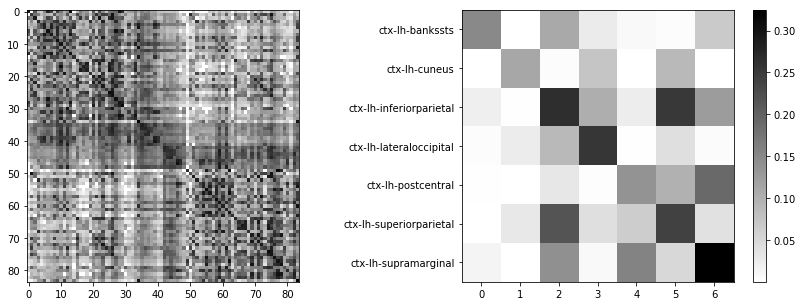

In [43]:
K_raw = loadtxt(path+ 'data/weights.txt')
K = K_raw * 1.0 / K_raw.sum(axis=1)[:, newaxis]
subplot(121)
imshow(log(K+1e-5), interpolation='nearest')

subplot(122)

imshow(K[nodes][:, nodes])
yticks(r_[:len(nodes)], [reg_names[i] for i in nodes]);
colorbar();

print "The final selected nodes are: ", nodes
print([reg_names[i] for i in unique(nodes)])
plt.show()

# plot (CU'3-4, ctx-lh-cuneus, ctx-lh-inferiorparietal) in red big circle in first figure

Then, according to selected contacts and nodes, the gain matrix is reduced to corresponding dimension. If we have N contacts and M nodes, the dimension of gain matrix is N $\times$ M.

In [44]:
Vr_ = Vr[picks][:, nodes]
Vr_ /= Vr_.sum(axis=1)[:, newaxis]
print 'reduced gain matrix shape is ', Vr_.shape 
#save('Vr_.npy', Vr_)

reduced gain matrix shape is  (6, 7)


The connectivity matrix should also be reduced according to the selected nodes.

In [45]:
W = loadtxt(path+ 'data/weights.txt')
iconst = setxor1d(r_[:W.shape[0]], nodes)
for i in range(W.shape[0]):
    W[i, i] = 0.0
W /= W.max()
W_ = W[nodes][:, nodes]
Ic = W[nodes][:, iconst].sum(axis=1)

In [46]:
#tm = c_[T>0., T<5.].all(axis=1)
tm = c_[T>0.6, T<4.6].all(axis=1)
T = T[tm]
print 'ps  shape is ', ps.shape 
ps = ps[picks][:, tm]
print 'ps shape now is ', ps.shape 

ps  shape is  (162, 501)
ps shape now is  (6, 400)


In [47]:
t0 = 0.0
Tend = array([(len(T)+1)*dt] , dtype='float32')

ts = arange(dt,Tend,dt)

Finally here is the fitting target:

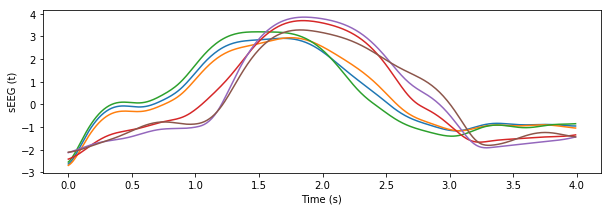

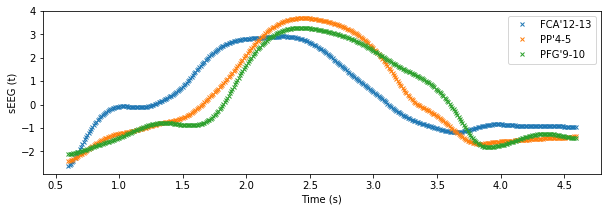

In [48]:
figure(figsize=(10, 3))
for i in range(0, len(ps)):
    plot(arange(ps.shape[1])*dt, ps[i,:])
ylabel('sEEG (t)');
xlabel('Time (s)');
plt.show()

#[50, 51, 67, 80, 93, 109]    
showpicks = r_[0, 3, 5]

figure(figsize=(10, 3))
for i in showpicks:
    plot(T, ps[i,:].T, 'x', markersize=4)

leg = []
for i in [50, 80, 109]:
    cn = bipnames[i]
    leg.append(cn)
legend(leg)
ylabel('sEEG (t)');
xlabel('Time (s)');
plt.show()

### The following code, generates the "data.R" for running Stan Bayesian inference.

In [49]:
data_dict = {
    'nn': W_.shape[0], 'ns': Vr_.shape[0], 'nt': len(T),
    'I1': 3.1, 'tau0': 3.0, 'dt': dt, 't0': 0.0, 'ts': ts,
    'SC': W_, 'SC_var': 5.0, 'gain': Vr_, 'seeg_log_power': ps.T, 'Ic': Ic,
    'Ez_idx':4, 'Pz_idx': 3, 'x0c': -2.05, 'deltax0': 0.4,
    'K_lo': 1.0, 'K_hi': 30.0, 'K_u': 5.0, 'K_v': 10.0,
    'x0_lo': -4.0, 'x0_hi': -1.0 ,'sd_x0': 1.,
    'amp_lo': 1.0, 'amp_hi': 20.0, 
    'offset_lo': 0.25, 'offset_hi': 5.0, 
    'eps_hi': 0.05,  'sig_hi': 1.0,
    'zlim': r_[0.0, 10.0], 'xlim': r_[-2.5, 1.5],
}
    #  eps_hi': 0.25, 'sig_hi': 0.01, # for AdVI
    #  eps_hi': 0.05, 'sig_hi': 1.0, # for HMC



In [50]:
npz = {'nodes': nodes}
npz.update(data_dict)
np.savez(path+ 'dataSynthetic.R.npz', **npz)

In [51]:
#%run Rdump.py
#from Rdump import stan_rdump
pystan.stan_rdump(data_dict, path+  'dataSynthetic.R')

In [73]:
tic = time.time()

! cd $path && make ../vep

print(time.time() - tic, 'second is required to compile')

make: Nothing to be done for `../vep'.
(0.14626502990722656, 'second is required to compile')


In [65]:
tic = time.time()

!./vep variational  iter=30000 tol_rel_obj=0.001  data file=dataSynthetic.R output file=output.csv
#./vep sample algorithm=hmc  engine=nuts max_depth=15 num_samples=5000 num_warmup=500 adapt delta=0.9 data file=dataSynthetic.R output file=output.csv
print(time.time() - tic, 'second is required to run')

method = variational
  variational
    algorithm = meanfield (Default)
      meanfield
    iter = 1000
    grad_samples = 1 (Default)
    elbo_samples = 100 (Default)
    eta = 1 (Default)
    adapt
      engaged = 1 (Default)
      iter = 50 (Default)
    tol_rel_obj = 0.001
    eval_elbo = 100 (Default)
    output_samples = 1000 (Default)
id = 0 (Default)
data
  file = dataSynthetic.R
init = 2 (Default)
random
  seed = 3447482206
output
  file = output.csv (Default)
  diagnostic_file =  (Default)
  refresh = 100 (Default)

------------------------------------------------------------
EXPERIMENTAL ALGORITHM:
  This procedure has not been thoroughly tested and may be unstable
  or buggy. The interface is subject to change.
------------------------------------------------------------



Gradient evaluation took 0.022546 seconds
1000 transitions using 10 leapfrog steps per transition would take 225.46 seconds.
Adjust your expectations accordingly!


Begin eta adaptation.
Iteration:   1 / 

# Results

In [55]:
run  report.py output.csv